In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.layers import *
from keras.models import Sequential
from keras.optimizers import Adam

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/MyDrive/')

## Data preparing

In [ ]:
data = pd.read_csv('final_data.csv')

In [ ]:
data.drop('Unnamed: 0' ,axis=1, inplace=True)

In [ ]:
data.head()

,Year,Month,Day,Hour,Air pressure,Air temperature,RAD radiation,Precipitation,Realtive humidity,UVB radiation,CO,NO2,NOx,O3,PM2.5,PM10,SO2,C6H6
0,2015,1,1,0,1012.0,-6.6,0.0,62.8,1.6,278.0,0.575,18.0,20.0,7.0,19.0,NaN,35.778146,5.01000
1,2015,1,1,1,1011.0,-7.4,0.0,69.6,1.5,279.0,0.581,20.0,25.0,7.0,13.0,50.0,244.272000,5.25388
2,2015,1,1,2,1011.0,-7.1,0.0,72.3,1.4,286.0,0.678,20.0,25.0,6.0,11.0,34.0,102.633000,4.74133
3,2015,1,1,3,1012.0,-6.5,0.2,71.0,1.5,292.0,0.686,21.0,24.0,6.0,9.0,29.0,77.725900,4.66580
4,2015,1,1,4,1012.0,-5.6,0.0,69.2,1.7,299.0,0.653,22.0,25.0,6.0,10.0,21.0,69.562100,4.77038


In [ ]:
def prepare_data(data):
  #Preparing dataset for model
  data2015 = data[data.Year==2015]
  data_2015_by_day = data2015.groupby(['Month','Day']).mean()
  data_2015_by_day.reset_index(drop=True, inplace=True)
  data_2015_by_day.reset_index(drop=True, inplace=True)
  data_2015_by_day = data_2015_by_day['NOx']
  data2016 = data[data.Year==2016]
  data_2016_by_day = data2016.groupby(['Month','Day']).mean()
  data_2016_by_day.reset_index(drop=True, inplace=True)
  data_2016_by_day.reset_index(drop=True, inplace=True)
  data_2016_by_day = data_2016_by_day['NOx']
  data2017 = data[data.Year==2017]
  data_2017_by_day = data2017.groupby(['Month','Day']).mean()
  data_2017_by_day.reset_index(drop=True, inplace=True)
  data_2017_by_day.reset_index(drop=True, inplace=True)
  data_2017_by_day = data_2017_by_day['NOx']
  combine = [data_2015_by_day,data_2016_by_day,data_2017_by_day]
  data = pd.concat(combine)
  return data

In [ ]:
data = prepare_data(data)

In [ ]:
data.reset_index(drop=True, inplace=True)

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

## Train, test split

In [ ]:
train, test = data[0:728], data[728:1092]

## Model build

In [ ]:
window_size=7

In [ ]:
windowed_train = windowed_dataset(train, window_size, 10, 1096)

## Adjusting learning rate

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(44)
np.random.seed(44)

model = Sequential()
model.add(Lambda(lambda x: tf.expand_dims(x, axis=-1),
                 input_shape=[None]))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(1))
model.add(Lambda(lambda x: x * 100.0))

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

model.compile(loss='mse',
              optimizer=Adam(learning_rate=1e-8),
              metrics=["mse"])

history = model.fit(windowed_train, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
73/73 [==============================] - 7s 11ms/step - loss: 4759.6842 - mse: 4759.6842
Epoch 2/100
73/73 [==============================] - 1s 11ms/step - loss: 4756.3125 - mse: 4756.3125
Epoch 3/100
73/73 [==============================] - 1s 11ms/step - loss: 4752.3938 - mse: 4752.3938
Epoch 4/100
73/73 [==============================] - 1s 11ms/step - loss: 4747.9173 - mse: 4747.9173
Epoch 5/100
73/73 [==============================] - 1s 11ms/step - loss: 4743.0581 - mse: 4743.0581
Epoch 6/100
73/73 [==============================] - 1s 11ms/step - loss: 4737.8486 - mse: 4737.8486
Epoch 7/100
73/73 [==============================] - 1s 11ms/step - loss: 4732.0514 - mse: 4732.0514
Epoch 8/100
73/73 [==============================] - 1s 11ms/step - loss: 4725.4786 - mse: 4725.4786
Epoch 9/100
73/73 [==============================] - 1s 11ms/step - loss: 4718.0037 - mse: 4718.0037
Epoch 10/100
73/73 [==============================] - 1s 11ms/step - loss: 4709.4997 - mse:

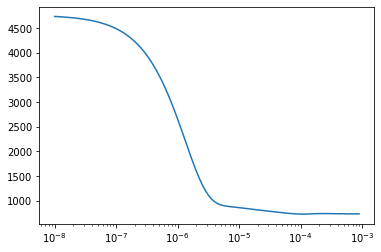

In [ ]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])

## Simple forecast

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(44)
np.random.seed(44)

model = Sequential()
model.add(Lambda(lambda x: tf.expand_dims(x, axis=-1),
                 input_shape=[None]))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(1))
model.add(Lambda(lambda x: x * 100.0))

model.compile(loss='mse',
              optimizer=Adam(learning_rate=1e-3),
              metrics=["mse"])

history = model.fit(windowed_train, epochs=500)

Epoch 1/500
73/73 [==============================] - 7s 11ms/step - loss: 1370.3838 - mse: 1370.3838
Epoch 2/500
73/73 [==============================] - 1s 11ms/step - loss: 763.3460 - mse: 763.3460
Epoch 3/500
73/73 [==============================] - 1s 12ms/step - loss: 718.8318 - mse: 718.8318
Epoch 4/500
73/73 [==============================] - 1s 12ms/step - loss: 696.3120 - mse: 696.3120
Epoch 5/500
73/73 [==============================] - 1s 12ms/step - loss: 689.2063 - mse: 689.2063
Epoch 6/500
73/73 [==============================] - 1s 12ms/step - loss: 690.8516 - mse: 690.8516
Epoch 7/500
73/73 [==============================] - 1s 12ms/step - loss: 699.9183 - mse: 699.9183
Epoch 8/500
73/73 [==============================] - 1s 11ms/step - loss: 711.1414 - mse: 711.1414
Epoch 9/500
73/73 [==============================] - 1s 12ms/step - loss: 710.5822 - mse: 710.5822
Epoch 10/500
73/73 [==============================] - 1s 12ms/step - loss: 694.1917 - mse: 694.1917
Epoch 1

In [ ]:
forecast = []

for time in range(len(data)- window_size):
  forecast.append(model.predict(data.values[time:time + window_size][np.newaxis]))

forecast = forecast[728-window_size:]
results = np.array(forecast)[:,0,0]

plt.figure(figsize=(14,7))

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

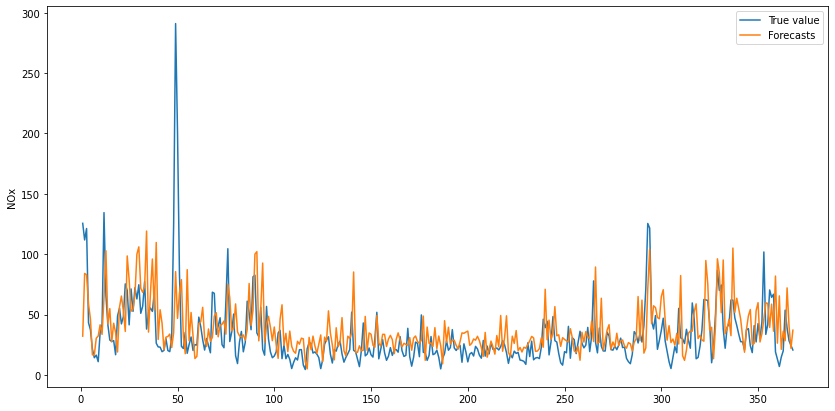

In [ ]:
plt.figure(figsize=(14,7))

timestamp = np.arange(1, len(data[728:])+1)
ax = sns.lineplot(timestamp , data[728:], label = 'True value')
ax1 = sns.lineplot(timestamp, results, label = 'Forecasts')

plt.show()

In [34]:
print('Annual RMSE: {}'.format(np.sqrt(mean_squared_error(data[728:], results))))
print('Annual MAE: {}'.format(mean_absolute_error(data[728:], results)))

Annual RMSE: 26.138855274996875
Annual MAE: 17.18971688807971
